# Subreddit Stats

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as md
import numpy as np
import praw
from psaw import PushshiftAPI
import datetime
import yaml
import time
from sortedcontainers import SortedDict
from collections import OrderedDict
import os.path
import pickle

## Parameters

In [2]:
start_epoch = int(datetime.datetime(2018, 1, 1).timestamp())
start_subs = 659       # number of subs at start_epoch (needed if before 2018/3/15, see redditmetrics.com)
#end_epoch = int(datetime.datetime(2019, 1, 1).timestamp())
end_epoch = int(time.time())
max_posts = 10000      # max number of posts to crawl, None for unlimited
sub = 'dreamcatcher'   # subreddit to crawl
num_score_calls = 10   # number of times to query score to mitigate reddit's score fuzzing
                       #     note: will drastically increase data acquisition time
cache_file = 'cache.pkl'    # cache file
skip_cache_days = 7 # skip cache for posts younger than this
secs_in_day = 86400

## Get Data

In [3]:
class Comment:
    def __init__(self):
        self.id = ''
        self.body = ''
        self.author = ''
        self.score = 0
        self.ts = 0
        self.url = ''
        self.score_arr = np.zeros((num_score_calls))

class Post:
    def __init__(self):
        self.id = ''
        self.title = ''
        self.author = ''
        self.ts = 0
        self.score = 0
        self.comments = []
        self.url = ''
        self.score_arr = np.zeros((num_score_calls))

In [4]:
def getSubComments(comment, allComments, verbose=True):
    allComments.append(comment)
    if not hasattr(comment, "replies"):
        replies = comment.comments()
    if verbose:
        print("fetching (" + str(len(allComments)) + " comments fetched total)")
    else:
        replies = comment.replies
    for child in replies:
        getSubComments(child, allComments, verbose=verbose)


def getAll(r, submissionId, verbose=True):
    submission = r.submission(submissionId)
    submission.comments.replace_more(limit=None)
    comments = submission.comments
    commentsList = []
    for comment in comments:
        getSubComments(comment, commentsList, verbose=verbose)
    return commentsList

def save_obj(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [5]:
stream = open('client_info.txt', 'r')
doc = yaml.load(stream)

r = praw.Reddit(client_id=doc['client_id'],
                client_secret=doc['client_secret'],
                user_agent='test'
                )
api_ps_praw = PushshiftAPI(r)
api_ps = PushshiftAPI()
post_ids = api_ps_praw.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['url', 'author', 'title', 'subreddit'],
                                  limit=max_posts)
subs = api_ps.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['subreddit', 'id', 'subreddit_subscribers'],
                                  limit=max_posts)
id2subs = {}

for s in subs:
    if hasattr(s, 'subreddit_subscribers'):
        num_subs = s.subreddit_subscribers
    else:
        num_subs = -1    
    id2subs[s.id] = num_subs
            
if os.path.isfile(cache_file):
    posts, subcount_temp = load_obj(cache_file)
    print('cache found')
else:
    posts = OrderedDict()
    subcount_temp = SortedDict()
prev_info_len = 1
temp_score_arr = np.zeros((num_score_calls))
print('fetching data...')
for i, post_id in enumerate(post_ids):
    if post_id.id not in posts or \
            posts[post_id.id].ts + skip_cache_days*secs_in_day > time.time():
        submission = praw.models.Submission(r, id=post_id)
        ts = int(submission.created_utc)
        ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
        subcount_temp[ts] = id2subs[post_id.id]

        c_temp = getAll(r, post_id, verbose=False)
        c = [Comment() for _ in range(len(c_temp))]

        for k, comment in enumerate(c_temp):
            c[k].body = comment.body
            c[k].author = comment.author
            c[k].ts = comment.created_utc
            c[k].score = comment.score
            c[k].url = comment.permalink
            c[k].id = comment.id
            c[k].score_arr[0] = comment.score

        for j in range(1, num_score_calls):
            c_temp = getAll(r, post_id, verbose=False)
            for k, comment in enumerate(c_temp):
                c[k].score_arr[j] = comment.score

        temp = Post()
        temp.id = submission.id
        temp.title = submission.title
        temp.author = submission.author
        temp.ts = submission.created_utc
        temp.comments = c
        temp.url = submission.permalink
        for j in range(num_score_calls):
            submission = praw.models.Submission(r, id=post_id)
            temp.score_arr[j] = submission.score
        posts[temp.id] = temp
        save_obj(cache_file, [posts, subcount_temp])
    else:
        ts = int(posts[post_id.id].ts)
        ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    
    title = (posts[post_id.id].title[:47] + '...') if len(posts[post_id.id].title) > 47 else posts[post_id.id].title
    info = '%05d: %s --- %s' % (i, ts_str, title)
    clear = ' ' * prev_info_len
    print('%s' % clear, end='\r', flush=True)
    prev_info_len = len(info)
    print('%s' % info, end='\r', flush=True)

    
for key, post in posts.items():
    post.score = np.median(post.score_arr) - 1
    for comment in post.comments:
        comment.score = np.median(comment.score_arr) - 1
    
print('\ndone')

cache found
fetching data...
03624: 2018-01-01 15:20:23 --- Dreamcatcher end of year awards                   ..
done


## Visualize Data

### Subscriber Growth

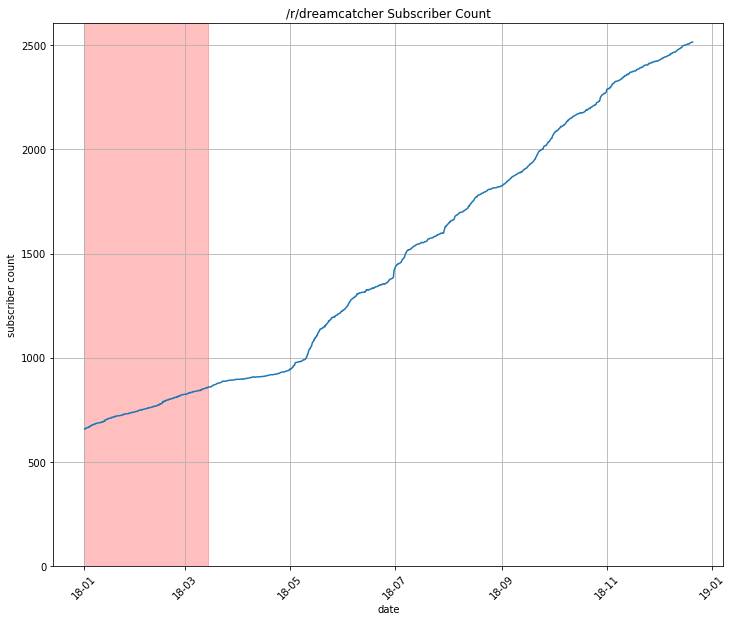

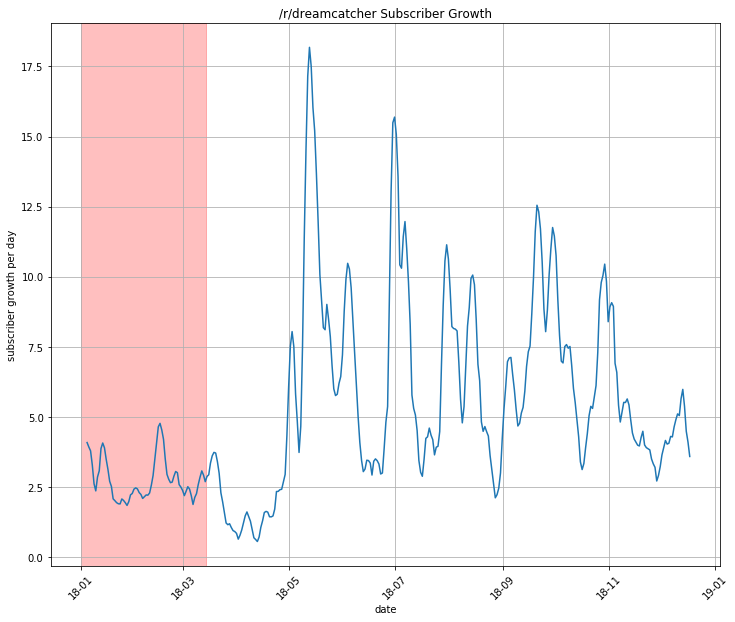

In [6]:
kernel_size = 7

# fix (interpolate) bad sub count data
timestamps = np.zeros(len(subcount_temp))
subs = np.zeros(len(subcount_temp))
no_sub_data_end = -1
temp = 0
for i, ts in enumerate(subcount_temp):
    timestamps[i] = ts
    subs[i] = subcount_temp[ts]
    if subs[i] == -1:
        no_sub_data_end = i
        
    # sanity check for large spikes because pushshift gave bad data
    elif temp != 0 and subs[i] < subs[temp] - 100:
        subs[temp] = (subs[i] + subs[i-2])/2
    temp = i
        
if start_subs is not None:
    if no_sub_data_end < len(subs)+1:
        subs[:no_sub_data_end+1] = np.floor(np.linspace(start_subs, subs[no_sub_data_end+1], no_sub_data_end+1))
        
start_epoch_date = datetime.datetime.fromtimestamp(start_epoch)
no_sub_data_end_date = datetime.datetime.fromtimestamp(timestamps[no_sub_data_end])


subcount = SortedDict()
for i, s in enumerate(subs):
    subcount[timestamps[i]] = s
# sub count
        
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    
plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, subs)
plt.ylim(bottom=0)
plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber count')
plt.title('/r/%s Subscriber Count' % (sub))
plt.grid(b=True, which='both', axis='both')

# sub growth


ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

sub_growth_ts = []
sub_growth = []
while ts_end < end_epoch:
    it = subcount.irange(ts_begin, ts_end)
    temp_ts = []
    temp_subcount = []
    for ts in it:
        temp_ts.append(ts)
        temp_subcount.append(subcount[ts])
    if len(temp_ts) != 0:
        p_fit = np.polyfit(temp_ts, temp_subcount, 1)
        sub_growth_ts.append((ts_begin + ts_end)/2)
        sub_growth.append(p_fit[0])
    ts_begin += secs_in_day
    ts_end += secs_in_day

dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in sub_growth_ts])
sub_growth = np.array(sub_growth) * secs_in_day

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, sub_growth)
plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber growth per day')
plt.title('/r/%s Subscriber Growth' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()



### Post and Comment Frequency

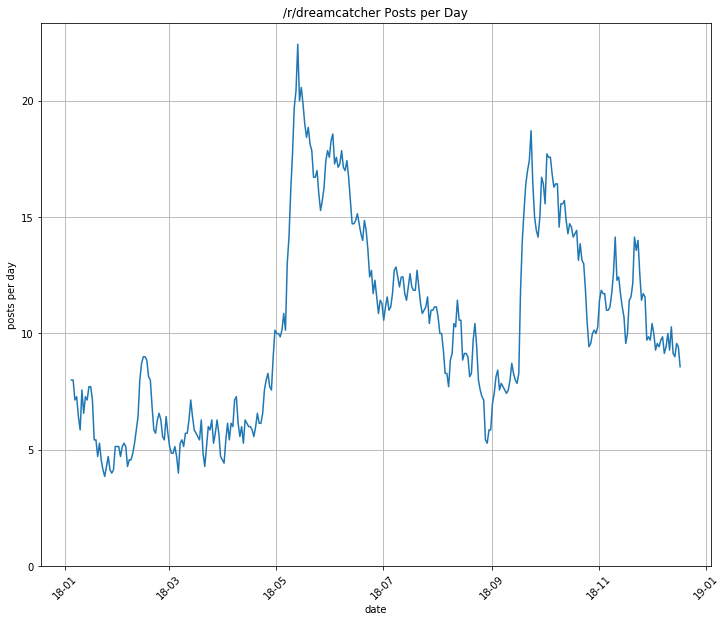

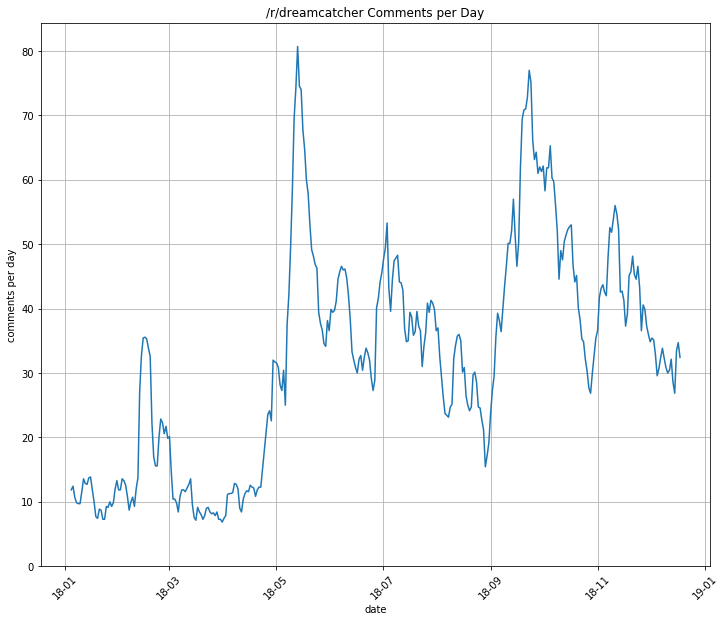

In [7]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    
    
# posts per day
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_freq_ts = []
post_freq = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_freq_ts.append(ts)
        post_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_freq_ts])
post_freq = np.array(post_freq) / kernel_size

if len(post_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, post_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('posts per day')
    plt.title('/r/%s Posts per Day' % (sub))
    plt.grid(b=True, which='both', axis='both')

# comments per day
chron_comments = SortedDict()
for key, post in posts.items():
    for comment in post.comments:
        chron_comments[comment.ts] = comment

ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_freq_ts = []
comment_freq = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_freq_ts.append(ts)
        comment_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_freq_ts])
comment_freq = np.array(comment_freq) / kernel_size

if len(comment_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, comment_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('comments per day')
    plt.title('/r/%s Comments per Day' % (sub))
    plt.grid(b=True, which='both', axis='both')

plt.show()

### Make Score Adjustments

In [8]:
all_ts = np.zeros((len(chron_posts)))
all_scores = np.zeros((len(chron_posts)))

for i, ts in enumerate(chron_posts):
    all_ts[i] = ts - start_epoch
    all_scores[i] = chron_posts[ts].score
    
all_comment_ts = np.zeros((len(chron_comments)))
all_comment_scores = np.zeros((len(chron_comments)))

for i, ts in enumerate(chron_comments):
    all_comment_ts[i] = ts - start_epoch
    all_comment_scores[i] = chron_comments[ts].score
        
post_slope, post_int = np.polyfit(all_ts, all_scores, 1)
comment_slope, comment_int = np.polyfit(all_comment_ts, all_comment_scores, 1)

def calc_adj(ts, score):
    frac_time = (ts - start_epoch) / (end_epoch - start_epoch)
    scalar = score / (frac_time*(end_epoch-start_epoch)*post_slope+post_int)
    adj_score = (post_int+(end_epoch-start_epoch)*post_slope) * scalar
    return float(adj_score)
def calc_comment_adj(ts, score):
    frac_time = (ts - start_epoch) / (end_epoch - start_epoch)
    scalar = score / (frac_time*(end_epoch-start_epoch)*comment_slope+comment_int)
    adj_score = (comment_int+(end_epoch-start_epoch)*comment_slope) * scalar
    return float(adj_score)

### Average Post and Comment Scores

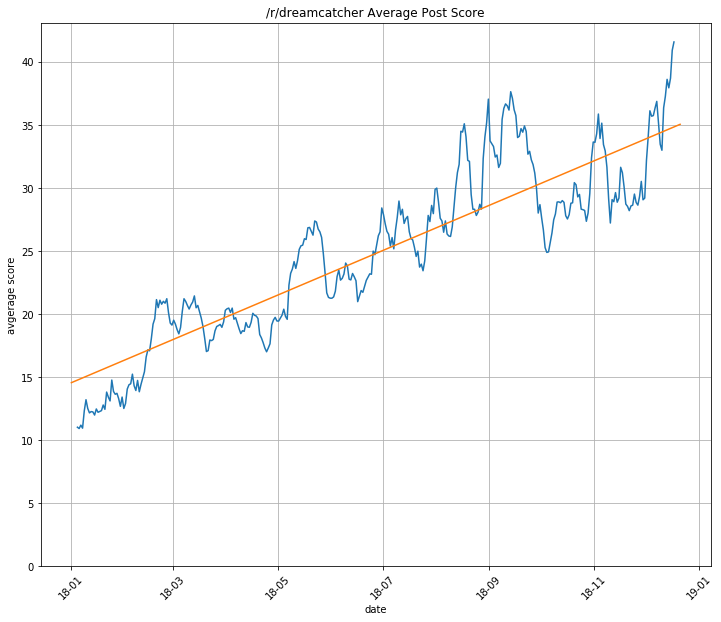

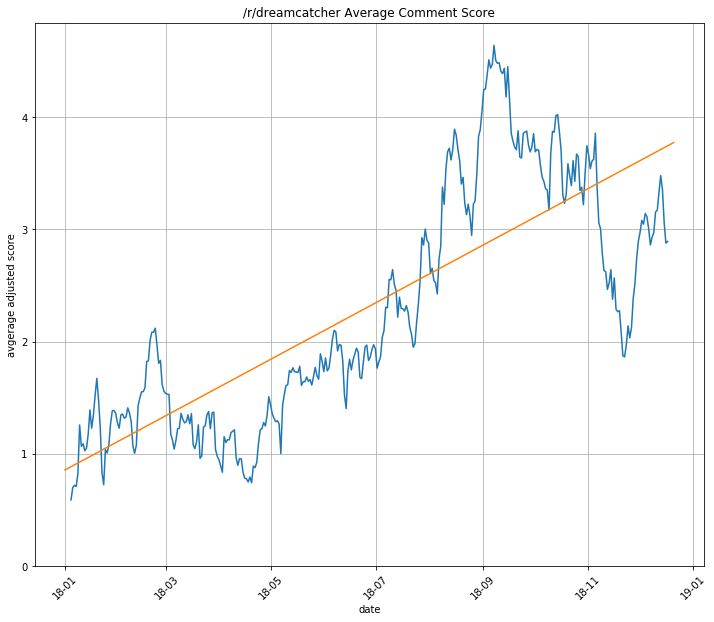

In [9]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    
    
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_score_ts = []
post_avg_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_score = 0
    count = 0
    for ts in it:
        total_score += chron_posts[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_score_ts.append(ts)
        post_avg_score.append(total_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_freq_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_score)
plt.plot([datetime.datetime.fromtimestamp(ts) for ts in [start_epoch, end_epoch]],
         [post_int, post_int+post_slope*(end_epoch-start_epoch)])
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage score')
plt.title('/r/%s Average Post Score' % (sub))
plt.grid(b=True, which='both', axis='both')

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += chron_comments[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.plot([datetime.datetime.fromtimestamp(ts) for ts in [start_epoch, end_epoch]],
         [comment_int, comment_int+comment_slope*(end_epoch-start_epoch)])
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Comment Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

### Average Adjusted Post and Comment Scores

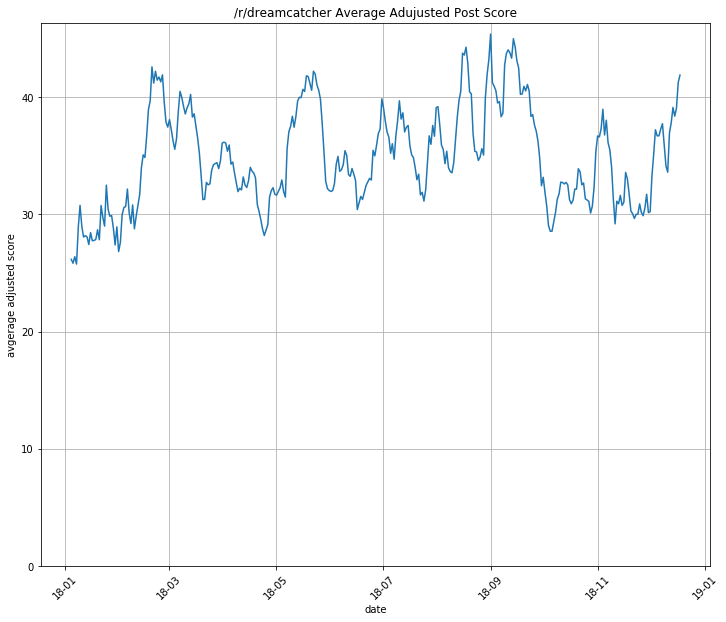

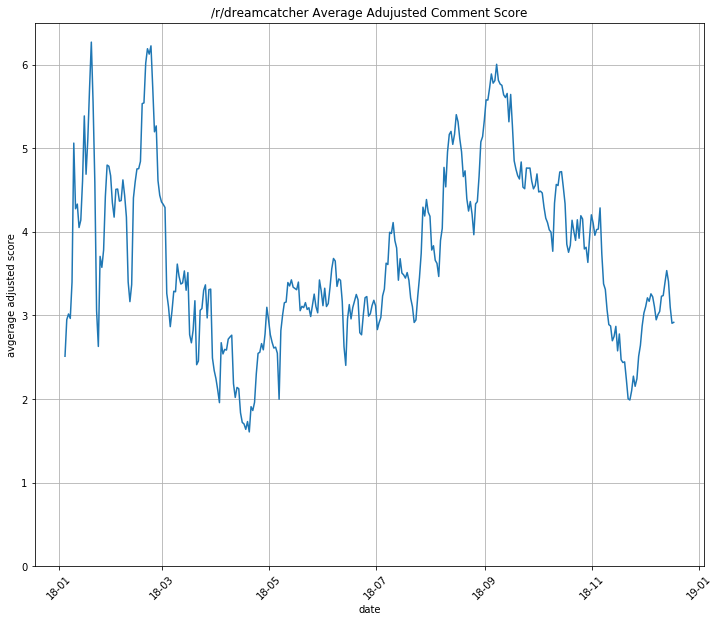

In [10]:
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_adj_score_ts = []
post_avg_adj_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_adj_score = 0
    count = 0
    for ts in it:
        total_adj_score += calc_adj(ts, chron_posts[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_adj_score_ts.append(ts)
        post_avg_adj_score.append(total_adj_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_adj_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Post Score' % (sub))
plt.grid(b=True, which='both', axis='both')

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += calc_comment_adj(ts, chron_comments[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Comment Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

## Leaderboards

### Top Posts

In [11]:
adj_scores = np.zeros((len(posts)), dtype=float)
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    adj_scores[i] = calc_adj(ts, post.score)

top_idx = (-adj_scores).argsort()[:10]

posts_list = list(posts)
for i, idx in enumerate(top_idx):
    post = posts[posts_list[idx]]
    ts = int(post.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top post #%d' % (i+1))
    print('title:          %s' % (post.title))
    print('author:         %s' % (post.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (post.score))
    print('adjusted score: %f' % (calc_adj(post.ts, post.score)))
    print('comments:       %d' % (len(post.comments)))
    print('permalink:      https://www.reddit.com%s' % (post.url))
    print()

top post #1
title:          Dreamcatcher (드림캐쳐) - 'YOU AND I' MV
author:         SpideyCyclist
time:           2018-05-10 09:01:59
score:          172
adjusted score: 273.603544
comments:       15
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8idh2r/dreamcatcher_드림캐쳐_you_and_i_mv/

top post #2
title:          Dreamcatcher (드림캐쳐) - 'What' MV
author:         SpideyCyclist
time:           2018-09-20 09:00:45
score:          191
adjusted score: 225.760545
comments:       35
permalink:      https://www.reddit.com/r/dreamcatcher/comments/9hdotl/dreamcatcher_드림캐쳐_what_mv/

top post #3
title:          New Fans Guide To Dreamcatcher
author:         SpideyCyclist
time:           2018-05-10 13:41:43
score:          122
adjusted score: 193.968664
comments:       29
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8ieyin/new_fans_guide_to_dreamcatcher/

top post #4
title:          Dami, please..
author:         myblindy
time:           2018-05-11 15:08:56
score:      

### Top Comments

In [12]:
all_comments = []
comment_ts2post_ts = None
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    for comment in post.comments:
        all_comments.append(comment)
#         if comment.ts not in comment_ts2post_ts:
#             comment_ts2post_ts[comment.ts] = ts

adj_scores = np.zeros((len(all_comments)), dtype=float)
for i, comment in enumerate(all_comments):
    ts = int(comment.ts)
    adj_scores[i] = calc_comment_adj(ts, comment.score)
    
top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    comment = all_comments[idx]
    body = comment.body.replace('\n', ' ')
    body = (body[:97] + '...') if len(body) > 97 else body
    ts = int(comment.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top comment #%d' % (i+1))
    print('comment:        %s' % (body))
    print('author:         %s' % (comment.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (comment.score))
    print('adjusted score: %f' % (adj_scores[idx]))
    print('permalink:      https://www.reddit.com%s' % (comment.url))
    print()

top comment #1
comment:        Oh. My. God.   I made that jumper for her! Gave it to her in London!!! Freaking out a little bit....
author:         davefeeder
time:           2018-02-20 06:44:30
score:          19
adjusted score: 56.465462
permalink:      https://www.reddit.com/r/dreamcatcher/comments/7yttg6/yoohyeon_shark_doo_doo_doo_doo_doo_doo/duj5inx/

top comment #2
comment:        Hi everyone,  International fans \- this day is dedicated to you. After working tirelessly with H...
author:         DCUnion-Astraea
time:           2018-06-01 11:29:20
score:          30
adjusted score: 53.825254
permalink:      https://www.reddit.com/r/dreamcatcher/comments/8nr4bi/eng_subs_available_on_dreamcatcher_videos/dzxndb0/

top comment #3
comment:        Everybody's rushing to check if she's okay while Gahyeon's busy laughing her ass off. This maknae...
author:         CDN_Datawraith
time:           2018-05-20 18:55:44
score:          21
adjusted score: 39.485184
permalink:      https://www.re

### Top Posters

In [13]:
users = OrderedDict()
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    if post.author == None:
        continue
    if post.author not in users:
        users[post.author] = {}
        users[post.author]['score'] = 0
        users[post.author]['adj_score'] = 0
        users[post.author]['posts'] = 0
        users[post.author]['comment_score'] = 0
        users[post.author]['adj_comment_score'] = 0
        users[post.author]['comments'] = 0
    users[post.author]['score'] += post.score
    users[post.author]['adj_score'] += calc_adj(ts, post.score)
    users[post.author]['posts'] += 1
    for comment in post.comments:
        if comment.author not in users:
            users[comment.author] = {}
            users[comment.author]['score'] = 0
            users[comment.author]['adj_score'] = 0
            users[comment.author]['posts'] = 0
            users[comment.author]['comment_score'] = 0
            users[comment.author]['adj_comment_score'] = 0
            users[comment.author]['comments'] = 0
        users[comment.author]['comment_score'] += comment.score
        users[comment.author]['adj_comment_score'] += calc_comment_adj(comment.ts, comment.score)
        users[comment.author]['comments'] += 1

In [14]:
sorted_posters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_score'], reverse=True))

for i, key in enumerate(sorted_posters):
    if i >= 10:
        break
    print('top poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('total number of posts: %d' % (sorted_posters[key]['posts']))
    print('total score:           %d' % (sorted_posters[key]['score']))
    print('total adjusted score:  %f' % (sorted_posters[key]['adj_score']))
    print()

top poster #1
user:                  SpideyCyclist
total number of posts: 2544
total score:           67305
total adjusted score:  92395.133001

top poster #2
user:                  myblindy
total number of posts: 72
total score:           3508
total adjusted score:  5418.779087

top poster #3
user:                  kyunikeon
total number of posts: 111
total score:           4210
total adjusted score:  4627.693856

top poster #4
user:                  CDN_Datawraith
total number of posts: 89
total score:           2504
total adjusted score:  3155.178892

top poster #5
user:                  vagabond2787
total number of posts: 36
total score:           1535
total adjusted score:  1671.987730

top poster #6
user:                  GenghisKhaii
total number of posts: 40
total score:           1146
total adjusted score:  1472.429945

top poster #7
user:                  nat1withadv
total number of posts: 35
total score:           1136
total adjusted score:  1241.973427

top poster #8
user: 

## Top Commenters

In [15]:
sorted_commenters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_commenters):
    if i >= 10:
        break
    print('top commenter #%d' % (i+1))
    print('user:                          %s' % (key))
    print('total number of comments:      %d' % (sorted_commenters[key]['comments']))
    print('total comment score:           %d' % (sorted_commenters[key]['comment_score']))
    print('total adjusted comment score:  %f' % (sorted_commenters[key]['adj_comment_score']))
    print()

top commenter #1
user:                          SpideyCyclist
total number of comments:      3105
total comment score:           6053
total adjusted comment score:  9027.526512

top commenter #2
user:                          internet0jesus
total number of comments:      1077
total comment score:           3779
total adjusted comment score:  4957.320597

top commenter #3
user:                          dreamcatcherERA
total number of comments:      354
total comment score:           1107
total adjusted comment score:  1629.417451

top commenter #4
user:                          Darrens_Coconut
total number of comments:      260
total comment score:           1034
total adjusted comment score:  1353.034070

top commenter #5
user:                          ipwnmice
total number of comments:      267
total comment score:           933
total adjusted comment score:  1248.398488

top commenter #6
user:                          kyunikeon
total number of comments:      324
total comment score: 

## Top Average Users

In [16]:
temp = OrderedDict()
for user in users:
    if user not in temp:
        temp[user] = {}
        
    if users[user]['posts'] == 0:
        temp[user]['avg_adj_score'] = 0;
    else:
        temp[user]['avg_adj_score'] = users[user]['adj_score'] / users[user]['posts']
        
    if users[user]['comments'] == 0:
        temp[user]['avg_adj_comment_score'] = 0;
    else:
        temp[user]['avg_adj_comment_score'] = users[user]['adj_comment_score'] / users[user]['comments']


In [17]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_score'], reverse=True))

i = 0;
for key in sorted_avg_posters:
    if i >= 10:
        break
    if users[key]['posts'] < 10:
        continue
    print('top avg poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('avg adjusted score:    %f' % (sorted_avg_posters[key]['avg_adj_score']))
    print('total number of posts: %d' % (users[key]['posts']))
    print('total score:           %d' % (users[key]['score']))
    print('total adjusted score:  %f' % (users[key]['adj_score']))
    print()
    i += 1

top avg poster #1
user:                  AmaryllisDC
avg adjusted score:    89.679359
total number of posts: 11
total score:           671
total adjusted score:  986.472948

top avg poster #2
user:                  myblindy
avg adjusted score:    75.260821
total number of posts: 72
total score:           3508
total adjusted score:  5418.779087

top avg poster #3
user:                  Naienitsugua
avg adjusted score:    49.565723
total number of posts: 21
total score:           810
total adjusted score:  1040.880173

top avg poster #4
user:                  vagabond2787
avg adjusted score:    46.444104
total number of posts: 36
total score:           1535
total adjusted score:  1671.987730

top avg poster #5
user:                  foxhound-delta
avg adjusted score:    44.836067
total number of posts: 13
total score:           295
total adjusted score:  582.868871

top avg poster #6
user:                  ipwnmice
avg adjusted score:    42.867178
total number of posts: 14
total score:  

In [18]:
sorted_avg_commenters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_comment_score'], reverse=True))

i = 0
for key in sorted_avg_commenters:
    if i >= 10:
        break
    if users[key]['comments'] < 30:
        continue
    print('top avg commenter #%d' % (i+1))
    print('user:                         %s' % (key))
    print('avg adjusted comment score:   %f' % (sorted_avg_commenters[key]['avg_adj_comment_score']))
    print('total number of comments:     %d' % (users[key]['comments']))
    print('total comment score:          %d' % (users[key]['comment_score']))
    print('total adjusted comment score: %f' % (users[key]['adj_comment_score']))
    print()
    i += 1

top avg commenter #1
user:                         IBrosiedon
avg adjusted comment score:   8.758766
total number of comments:     63
total comment score:          421
total adjusted comment score: 551.802288

top avg commenter #2
user:                         Yaong_
avg adjusted comment score:   7.509396
total number of comments:     34
total comment score:          164
total adjusted comment score: 255.319454

top avg commenter #3
user:                         _ulinity
avg adjusted comment score:   7.002737
total number of comments:     31
total comment score:          156
total adjusted comment score: 217.084856

top avg commenter #4
user:                         sheepheadcg
avg adjusted comment score:   6.801349
total number of comments:     55
total comment score:          140
total adjusted comment score: 374.074172

top avg commenter #5
user:                         VanRoyal
avg adjusted comment score:   6.145832
total number of comments:     45
total comment score:          163